In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split , KFold,GridSearchCV,train_test_split,cross_val_score ,learning_curve
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet

from sklearn.metrics import mean_absolute_error,mean_squared_error  
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import smogn

In [2]:
data = pd.read_csv('csv/cycle_data.csv')

In [3]:
data

,charge_cycle,max_height_ic,gaussian_height,normalize_height,auc_vt,slope_vt,Battery,SOH
0,1.0,2.756590,5.001875,0.973257,1150.119424,NaN,B0005,99.408284
1,2.0,5.172427,5.002491,0.973377,11386.989114,0.000156,B0005,98.816568
2,3.0,5.113697,5.003717,0.973616,11371.530747,0.000108,B0005,98.224852
3,4.0,5.071102,5.005545,0.973972,11287.752979,0.000108,B0005,97.633136
4,5.0,5.027662,5.007959,0.974441,11325.585534,0.000109,B0005,97.041420
...,...,...,...,...,...,...,...,...
1212,193.0,3.742927,3.915229,0.827889,5756.384401,0.000111,B0036,2.030457
1213,194.0,3.723729,3.913964,0.827621,5717.790058,0.000121,B0036,1.522843
1214,195.0,3.636837,3.913006,0.827419,5413.290340,0.000122,B0036,1.015228
1215,196.0,3.585013,3.912370,0.827284,5201.624129,0.000124,B0036,0.507614


In [34]:
features = ['gaussian_height','auc_vt','slope_vt','SOH']
df = data[features]
df = df.dropna()

In [35]:
X = df.drop('SOH',axis=1)
y = df['SOH']

In [36]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [46]:
X_sc.shape

array([[ 1.23354317,  1.74587526,  1.69450194],
       [ 1.23530758,  1.7396517 , -0.70435728],
       [ 1.23793925,  1.70592267, -0.67801962],
       ...,
       [-0.33451523, -0.65914318, -0.0110498 ],
       [-0.33543079, -0.74436025,  0.09574513],
       [-0.33589197, -0.87407404,  0.16295192]])

In [76]:
X_train,X_test,y_train,y_test = train_test_split(X_sc,y,test_size=0.2,random_state=101)

In [77]:
X_train.shape

(956, 3)

In [78]:
models = [RandomForestRegressor(),SVR(),ElasticNet(),LGBMRegressor()]
def base_model_errors(models,X,y):
    ind = []
    srs = []
    for model in models:
        scores = cross_val_score(estimator=model,X=X,y=y,cv=5)
        scores.sort()
        srs.append(scores)
        ind.append(str(model)[:-2])
    return pd.DataFrame(index=ind,data=srs,columns=['S1','S2','S3','S4','S5'])

In [79]:
error_df = base_model_errors(models=models,X=X_train,y=y_train)
error_df

,S1,S2,S3,S4,S5
RandomForestRegressor,0.907298,0.916640,0.922988,0.930271,0.934193
SVR,0.695576,0.699324,0.702895,0.714904,0.738392
ElasticNet,0.624592,0.628413,0.631260,0.634419,0.653635
LGBMRegressor,0.877408,0.897260,0.908628,0.917483,0.920063


In [80]:
def models_best_params(models,param_grids,X,y):
    for i in range(len(models)):
        gm = GridSearchCV(estimator=models[i],
                          param_grid=param_grids[i],
                         cv=5)
        gm.fit(X,y)
        print("%s 's best parameters are..'"%(str(models[i])))
        print(gm.best_params_)
        print("%s's best score is.."%(str(models[i])))
        print(gm.best_score_)

In [81]:
models2 = [RandomForestRegressor()]
param_grid = [

    {
        'n_estimators' : [80,90,100,110,120,130,140],
        'max_depth' : [4,5,6,7,None]
    }
]
models_best_params(models=models2,param_grids=param_grid,X=X_train,y=y_train)


RandomForestRegressor() 's best parameters are..'
{'max_depth': None, 'n_estimators': 80}
RandomForestRegressor()'s best score is..
0.924445458900246


In [82]:
model = RandomForestRegressor(n_estimators=80, max_depth=None)

In [83]:
model.fit(X_train,y_train)

RandomForestRegressor(n_estimators=80)

In [86]:
def cal_error(y_test,y_pred):
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    mae = mean_absolute_error(y_test,y_pred)
    print('RMSE:{}, MAE:{}'.format(rmse,mae))

In [88]:
y_pred = model.predict(X_test)
cal_error(y_test,y_pred)

RMSE:7.18175384416766, MAE:4.4501767855867


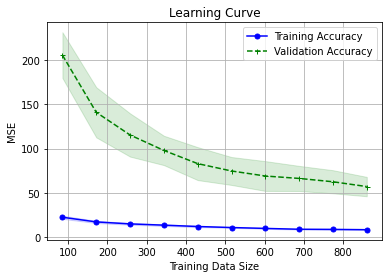

In [89]:
train_sizes, train_scores, test_scores = learning_curve(estimator=model, X=X_train, y=y_train,
                                                       cv=10, train_sizes=np.linspace(0.1, 1.0, 10),
                                                     n_jobs=1,scoring = 'neg_mean_squared_error')
#
# Calculate training and test mean and std
#
train_mean = -np.mean(train_scores, axis=1)
train_std = -np.std(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)
test_std = -np.std(test_scores, axis=1)
#
# Plot the learning curve
#
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('MSE')
plt.grid()
plt.legend(loc='upper right')
plt.show()